In [1]:
!pip3 install tensorflow_addons

     |████████████████████████████████| 1.8MB 3.4MB/s 
     |████████████████████████████████| 380.8MB 41kB/s 
     |████████████████████████████████| 3.8MB 44.8MB/s 
     |████████████████████████████████| 450kB 45.8MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      S

In [1]:
!pip3 install scikit-plot

%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import random as rn
import pandas as pd
import xarray
import requests
import datetime

import os
import numpy as np
from datetime import timedelta
from tqdm import tqdm_notebook as tqdm
import sklearn as skl
import seaborn as sns
import xgboost as xgb
from pathlib import Path
import scikitplot as skplt
from google.colab import files, drive
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import sklearn

import tensorflow as tf
import tensorflow.keras as keras

print(tf.test.gpu_device_name())
print(f'tf:{tf.__version__}')
print(f'keras:{tf.keras.__version__}')
print(f'sklearn:{sklearn.__version__}')
#assert ('0.22' == sklearn.__version__)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.pipeline import make_pipeline
if sklearn.__version__ == '0.22':
  from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import sklearn.ensemble

import warnings
warnings.filterwarnings('ignore')
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.6f}'.format

RS = 77
rn.seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)
os.environ['PYTHONHASHSEED']=str(RS)
if tf.__version__[:2] == '2.':
  tf.random.set_seed(RS)
else:
  tf.random.set_random_seed(RS)

GDRIVE_PATH = '/content/drive'
drive.mount(GDRIVE_PATH, force_remount=True)
PATH = os.path.join(GDRIVE_PATH, 'My Drive/crowdanalytix/', '')

Populating the interactive namespace from numpy and matplotlib
TensorFlow 2.x selected.
/device:GPU:0
tf:2.1.0-rc1
keras:2.2.4-tf
sklearn:0.21.3


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow_addons as tfa
from tensorflow_addons.optimizers import AdamW

In [3]:
df_train = pd.read_csv(os.path.join(PATH, 'CAX_LogFacies_Train_File.csv')) #, dtype={'field1': np.float64, 'field14': np.float64})
df_test = pd.read_csv(os.path.join(PATH, 'CAX_LogFacies_Test_File.csv'), index_col='unique_id') #, dtype={'field1': np.float64, 'field14': np.float64})
df_train.describe()

,row_id,well_id,GR,label
count,4400000.000000,4400000.000000,4400000.000000,4400000.000000
mean,549.500000,1999.500000,109.273256,1.184489
std,317.542553,1154.700634,34.242397,1.465016
min,0.000000,0.000000,-3.181915,0.000000
25%,274.750000,999.750000,81.792217,0.000000
50%,549.500000,1999.500000,120.384935,0.000000
75%,824.250000,2999.250000,134.729051,2.000000
max,1099.000000,3999.000000,197.061419,4.000000


In [0]:
X = df_train[['label', 'GR']]
X['id'] = df_train['well_id']*1100 + df_train['row_id']

data = pd.DataFrame(X, index=X['id']).drop(['id'], axis=1)

In [0]:
df_test.head()

In [0]:
df_train.tail()

In [0]:
df_test.describe()

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
df_train.hist(ax=ax);

In [0]:
def plot_cm_and_roc(model, X, y, title=''):
  
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  fig.patch.set_facecolor((1.0, 1.0, 1.0))
  fig.suptitle(f'{type(model).__name__} {title}')
  skl.metrics.plot_confusion_matrix(model, X, y, ax=ax1)
  skl.metrics.plot_roc_curve(model, X, y, ax=ax2)
  '''
  pred_proba = model.predict_proba(X, ntree_limit=model.best_ntree_limit)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
  fig.suptitle(f'{type(model).__name__} {title}')
  skplt.metrics.plot_confusion_matrix(y, pred_proba.argmax(axis=1), ax=ax1)
  skplt.metrics.plot_roc(y, pred_proba, ax=ax2)
  '''
  plt.show()

def oof_estimate_plot(model):
  X_oof, y_off = prepare_data(df_oof)
  plot_cm_and_roc(model, X_oof, y_off, 'oof')

  if hasattr(model, 'best_ntree_limit'): pred = model.predict_proba(X_oof, ntree_limit=model.best_ntree_limit) 
  else: pred = model.predict_proba(X_oof)

  oof = skl.metrics.roc_auc_score(y_off, pred[:, 1])
  del X_oof
  return oof

def plot_cv_scores(scores):
  # plot CV scores
  plt.figure()
  plt.xlabel('Number of folds')
  plt.ylabel('Cross validation score')
  plt.plot(range(1, len(scores) + 1), scores)
  plt.show()

def plot_history(history, metric_names):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.subplots(figsize=(15,4))

  num_plots = len(metric_names)

  for i in range(num_plots):
    plt.subplot(1,num_plots,i+1)
    plt.xlabel('Epoch')
    plt.ylabel(metric_names[i])
    plt.plot(hist['epoch'], hist[metric_names[i]],
            label='Train %s' % metric_names[i])
    plt.plot(hist['epoch'], hist['val_%s' % metric_names[i]],
            label = 'Val %s' % metric_names[i])
    plt.legend()
  
  plt.show()

## Neural Networks

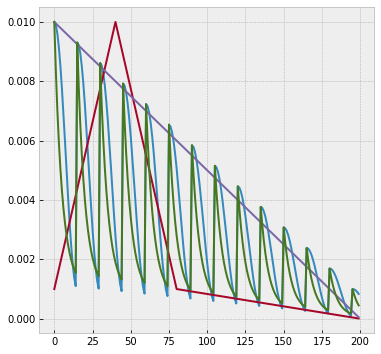

In [6]:
def annealing(x, cycle=15, max_lr=1e-2, min_lr=1e-3, epoches=200):
  decay_max = (max_lr - min_lr)*(x // cycle)/(epoches // cycle)
  max_lr = max_lr - decay_max
  decay_min = (min_lr-0)*(x // cycle)/(epoches // cycle)
  min_lr = min_lr - decay_min
  return min_lr + (max_lr - min_lr) * (1 + math.cos(np.pi * (x % cycle)/cycle)) / 2

def onecycle(x, cycle=80, max_lr=1e-2, min_lr=1e-3, epoches=200):
  halfcycle = cycle//2
  if x > cycle:
    lr = ((epoches-x)/epoches*epoches/(epoches-cycle))*(min_lr)
  elif x > halfcycle:
    lr = ((halfcycle-x)/halfcycle)*(max_lr-min_lr) + max_lr
  else:
    lr = (x/halfcycle)*(max_lr-min_lr) + min_lr
  return lr

def linear(x, max_lr=1e-2, min_lr=1e-3, epoches=200):
  return ((epoches-x)/epoches)*(max_lr)

def exponential(x, cycle=15, max_lr=1e-2, min_lr=1e-3, epoches=200):
  exp_res = [1.0, 0.8187307530779818, 0.6703200460356393, 0.5488116360940264, 0.44932896411722156, 0.36787944117144233, 0.301194211912202, 0.24659696394160643, 0.20189651799465538, 0.16529888822158653, 0.1353352832366127, 0.11080315836233387, 0.09071795328941247, 0.07427357821433388, 0.06081006262521795]
  decay_max = (max_lr - min_lr)*(x // cycle)/(epoches // cycle)
  max_lr = max_lr - decay_max
  decay_min = (min_lr-0)*(x // cycle)/(epoches // cycle)
  min_lr = min_lr - decay_min
  k = 0.2
  return min_lr + (max_lr - min_lr) * exp(-k * (x % cycle))
  #return min_lr + (max_lr - min_lr) * exp_res[x % cycle]

a = list(range(200))
b = [ annealing(x) for x in a ]
c = [ onecycle(x) for x in a ]
d = [ linear(x) for x in a ]
e = [ exponential(x) for x in a ]

plt.plot(a, b)
plt.plot(a, c)
plt.plot(a, d)
plt.plot(a, e)

In [0]:
!pip3 install keras_self_attention

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(50, 1100, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (50, 1100, 512)           397824    
_________________________________________________________________
dropout (Dropout)            (50, 1100, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (50, 1100, 256)           493056    
_________________________________________________________________
dropout_1 (Dropout)          (50, 1100, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (50, 1100, 128)           123648    
_________________________________________________________________
dropout_2 (Dropout)          (50, 1100, 128)           0     

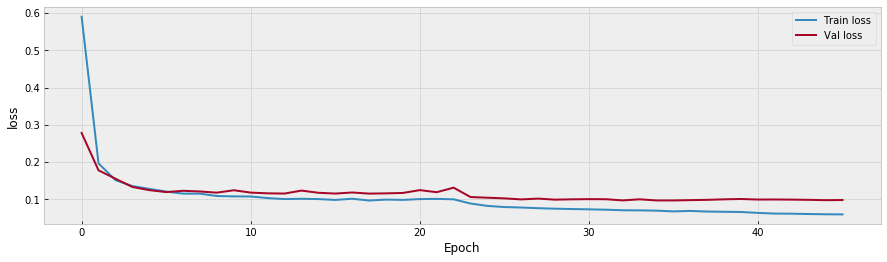

train loss: 0.05987 val loss:0.09731


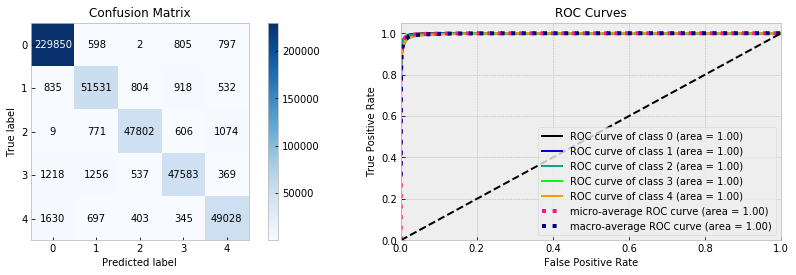

In [7]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow_addons.optimizers import Lookahead, RectifiedAdam
def lr_getter(self):
    return self._optimizer.learning_rate
def lr_setter(self, lr):
    self._optimizer.learning_rate = lr
def learning_rate_getter(self):
    return self._optimizer.learning_rate
def learning_rate_setter(self, learning_rate):
    self._optimizer.learning_rate = learning_rate
def patch_me(cls):
    cls.lr = property(lr_getter, lr_setter)
    cls.learning_rate = property(learning_rate_getter, learning_rate_setter)
patch_me(Lookahead)

tf.keras.backend.clear_session()
FEATURES_NUM = data.shape[1]-1
TARGET_TYPES = 5
EPOCHS = 200
BS = 50
BLOCK=1100

RS=777
rn.seed(RS)
np.random.seed(RS)
np.random.RandomState(RS)
os.environ['PYTHONHASHSEED']=str(RS)
if tf.__version__[:2] == '2.':
  tf.random.set_seed(RS)
else:
  tf.random.set_random_seed(RS)

X, y = data.iloc[:, 1:], data.iloc[:, :1]
#X, _, y, _ = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.5)
X_train, X_cv, y_train, y_cv = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.1)

center, scale = X_train.mean().values, X_train.std().values
X_train = (X_train.values - center)/scale
X_cv = (X_cv.values - center)/scale

y_train = y_train.values.ravel()
y_cv = y_cv.values.ravel()

#X_train = pad_sequences(X_train, maxlen=BLOCK)
X_train = X_train.reshape(-1, BLOCK, FEATURES_NUM)
y_train_ = y_train.reshape(-1, BLOCK, 1)

#X_cv = pad_sequences(X_train, maxlen=BLOCK)
X_cv = X_cv.reshape(-1, BLOCK, FEATURES_NUM)
y_cv_ = y_cv.reshape(-1, BLOCK, 1)

weight_decay = 0.03
inputs = Input(shape=(BLOCK, FEATURES_NUM,), batch_size=BS)
#x = Bidirectional(GRU(61, return_sequences=True, kernel_regularizer=l2(weight_decay)))(inputs)
x = Bidirectional(GRU(256, return_sequences=True))(inputs)
x = Dropout(0.5)(x)
x = Bidirectional(GRU(128, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Dropout(0.5)(x)
x = Bidirectional(GRU(61, return_sequences=True))(x)

# x, forward_h, backward_h = Bidirectional(GRU(64, return_sequences=True, return_state=True))(x)
# state_h = Concatenate()([forward_h, backward_h])
# x = Attention(512)([x, state_h])

out = Dense(TARGET_TYPES, activation='softmax')(x)
model = Model(inputs,out)

step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-4, 1e-5, 1e-6])
wd =  schedule(step)

lr = 1e-2
optimizer=Adam(learning_rate=lr)
#optimizer=AdamW(learning_rate=lr, weight_decay=5e-4)
#optimizer=Lookahead(optimizer)

model.compile(optimizer=optimizer,
              metrics=[#'sparse_categorical_crossentropy'
                      ], 
              loss='sparse_categorical_crossentropy'
              )
model.summary()
model.reset_states()

class ResetStatesCallback(Callback):
    def on_batch_begin(self, batch, logs):
        self.model.reset_states()

lr_schedule = ReduceLROnPlateau(verbose=1, factor=0.2 , patience=5, monitor='val_loss', mode='min')
#lr_schedule = LearningRateScheduler(lambda epoch: linear(epoch, max_lr=lr, min_lr=lr/10, epoches=EPOCHS))
#lr_schedule = LearningRateScheduler(lambda epoch: exponential(epoch, cycle=15, max_lr=lr, min_lr=lr/10, epoches=EPOCHS))
#lr_schedule = LearningRateScheduler(lambda epoch: onecycle(epoch, cycle=80, max_lr=lr, min_lr=lr/10, epoches=EPOCHS))

early_stop = EarlyStopping( patience=11, monitor='val_loss', mode='min' )
model_save = ModelCheckpoint( "my_checkpoint.h5", monitor='val_loss', save_best_only=True, mode='min' )
reset_states = ResetStatesCallback()

history = model.fit(X_train, y_train_,
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          use_multiprocessing=True,
          verbose=1,
          validation_data=(X_cv, y_cv_),
          callbacks=[early_stop, reset_states, model_save, lr_schedule]) #lr_schedule

model = load_model('my_checkpoint.h5')

plot_history(history, model.metrics_names)

print(f'train loss: {np.min(history.history["loss"]):.5f} val loss:{np.min(history.history["val_loss"]):.5f}')

model.reset_states()

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=fig.add_subplot(1, 2, 1))
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=fig.add_subplot(1, 2, 2))
plt.show()

In [0]:
GRU(70) 100% 50/1100 no annealing AdamW(5e-4) = 0.08436
GRU(64) 100% 50/1100 no annealing AdamW(5e-4) = 0.08369 lb=0.97261

GRU(58) 100% 50/1100 no annealing AdamW(5e-4) = 0.08318 lb=0.97349
GRU(58) 100% 50/1100 no annealing AdamW(5e-4) = 0.08214 lb=0.97335
GRU(58) 100% 50/1100 no annealing AdamW(5e-4) = 0.08255

GRU(58) 100% 50/1100 cos Annealing AdamW(5e-4) = 0.08535
GRU(58) 100% 50/1100 exp Annealing AdamW(5e-4) = 0.11...
GRU(*48*) 100% 50/1100 no annealing AdamW(5e-4) *d/o 05-05-05* = 0.08354
GRU(*48*) 100% 50/1100 no annealing AdamW(5e-4) no weight_decay layer1 = 0.08349

*LSTM*(58) 100% 50/1100 no annealing AdamW(5e-4) 0.5-0.5-0.5 = 0.08896

GRU(58) 100% 50/1100 no annealing AdamW(5e-4), no weight_decay, patience=15 = 0.08447
GRU(58) 100% 50/1100 no annealing AdamW(*1e-3*), patience=15 = 0.08775
GRU(58) 100% 50/1100 no annealing AdamW(*1e-4*), patience=15 = 0.08574

GRU(58) 100% 50/1100 no annealing AdamW(5e-4), Lookahead = 0.08449
GRU(58) 100% 50/1100 no annealing AdamW(5e-4), *3 layers * = 0.0851
GRU(58) 100% 50/1100 no annealing AdamW(5e-4), *5 layers * = 0.0839
GRU(*56*)100% 50/1100 no annealing AdamW(5e-4) = 0.0848
GRU(*60*)100% 50/1100 no annealing AdamW(5e-4) = 0.08305 lb=0.97339
GRU(*61*)100% 50/1100 no annealing AdamW(5e-4) *patience=(11,7)*= 0.08365
GRU(*61*)100% 50/1100 no annealing AdamW(5e-4) patience=(11,4) 05-04-03= 0.08281 <<<<<<
GRU(*61*)100% 50/1100 no annealing AdamW(5e-4) patience=(11,6) 05-04-03= 0.08730 ??? WTF
GRU(*61*)100% 50/1100 no annealing AdamW(5e-4) patience=(11,4) 05-04-03= 0.08466

GRU(61)100% 50/1100 no annealing AdamW(5e-4) patience=(11,4) 05-04-03 no weight_decay = 0.08166 [loss: 0.4970 - val_loss: 0.2192] lb=0.97237
GRU(61)100% 50/1100 no annealing AdamW(5e-4) patience=(11,4) 05-04-03 weight_decay = 0.08338 [loss: 0.5310 - val_loss: 0.2236]
GRU(61)100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) *05-05-05* no weight_decay = 0.08146 [0.4992, 0.2175] <<<<<<
GRU(61)100% 50/1100 no annealing AdamW(*1e-3*) patience=(11,5) 05-05-05 no weights decay = 0.08650 [0.5002, 0.2192]
GRU(61)100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 *-05* no weight_decay = 0.08209 [0.5616, 0.2123]
GRU(61) + *1.LSTM* 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08630 [0.4948, 0.2024]
GRU(61) + *2.LSTM* 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08436 [0.5139, 0.2325]
GRU(61) + *4.LSTM* 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08598 [0.4578, 0.2065]
GRU(61) *3 layers* 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08444 [0.5309, 0.2306]
GRU(61) *5 layers* 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08351 [0.5808, 0.2711]
GRU(61) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) *06-06-06* no weight_decay = 0.08388 [0.5009, 0.2391]
GRU(61) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) *04-04-04* no weight_decay = 0.08288 [0.4936, 0.2160]
GRU(61)100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay no batch size= 0.08146 [0.4992, 0.2175] <<<<<<
GRU(61)100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay *stateful=True*= 0.08438 [0.4992, 0.2175]
GRU(61)100% *100*/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08902 [0.6839, 0.2928]
GRU(61)100% *200*/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08608 [0.9767, 0.5451]
GRU(61) 100% 50/*550* no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.09358 [0.3734, 0.1756]

GRU(48) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08444 [0.5132, 0.2472]
GRU(58) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08444 [0.5132, 0.2472]
GRU(60) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08835 [0.5132, 0.2472]
GRU(62) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08511 [0.5132, 0.2472]

GRU(61-60-59-58) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay = 0.08865 [0.5296, 0.2426]
GRU(61) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay *RS=78* = 0.08765
GRU(61) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay *RS=777* = 0.08144 [0.4721, 0.2103?] <<<<<<
GRU(61) 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay *RS=79* = 0.08655
GRU(61) 100% 50/1100 no annealing SGDW(5e-4) patience=(11,5) 05-05-05 no weight_decay *RS=120* = 0.08233

GRU(61) 100% *25/1100* no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay *RS=777* = 0.08769
GRU(61) 100% *25/2200* no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay *RS=777* = 0.08750

GRU(61) 100% 50/2200 no annealing *Adam+Lookahead* patience=(11,5) 05-05-05 no weight_decay *RS=777* = 0.09387
+ dense(128) 0.08385
+ dense(5) 0.08856
GRU(61) + TimeDostributed 100% 50/1100 no annealing AdamW(5e-4) patience=(11,5) 05-05-05 no weight_decay *RS=777* = 0.08195 [0.4721, 0.2103]
 


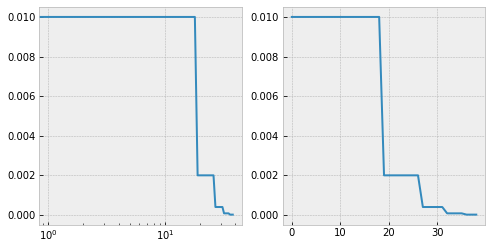

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4));
ax1.semilogx(history.epoch,history.history["lr"]);
ax2.plot(history.epoch,history.history["lr"]);

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(50, 1100, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (50, 1100, 122)           23424     
_________________________________________________________________
dropout (Dropout)            (50, 1100, 122)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (50, 1100, 122)           67710     
_________________________________________________________________
dropout_1 (Dropout)          (50, 1100, 122)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (50, 1100, 122)           67710     
_________________________________________________________________
dropout_2 (Dropout)          (50, 1100, 122)           0     

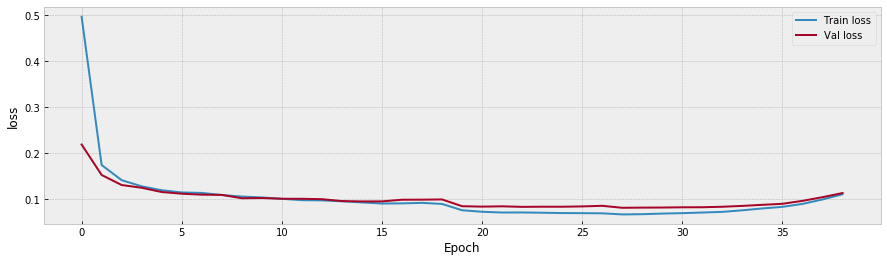

BS:50 train loss: 0.06725 val loss:0.08166


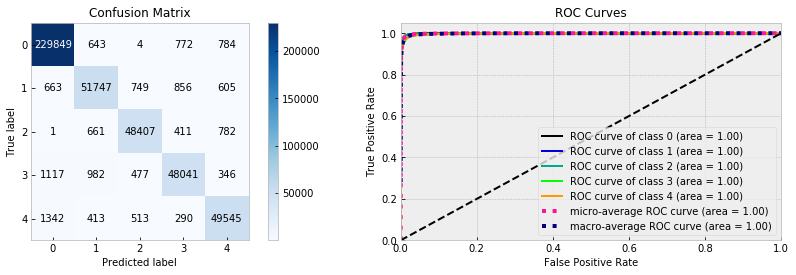

In [21]:
model = tf.keras.models.load_model('my_checkpoint.h5')
model.summary()

plot_history(history, model.metrics_names)

print(f'BS:{BS} train loss: {np.min(history.history["loss"]):.5f} val loss:{np.min(history.history["val_loss"]):.5f}')

model.reset_states()

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
plt.show()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(50, 1100, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (50, 1100, 122)           23424     
_________________________________________________________________
dropout (Dropout)            (50, 1100, 122)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (50, 1100, 122)           67710     
_________________________________________________________________
dropout_1 (Dropout)          (50, 1100, 122)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (50, 1100, 122)           67710     
_________________________________________________________________
dropout_2 (Dropout)          (50, 1100, 122)           0     

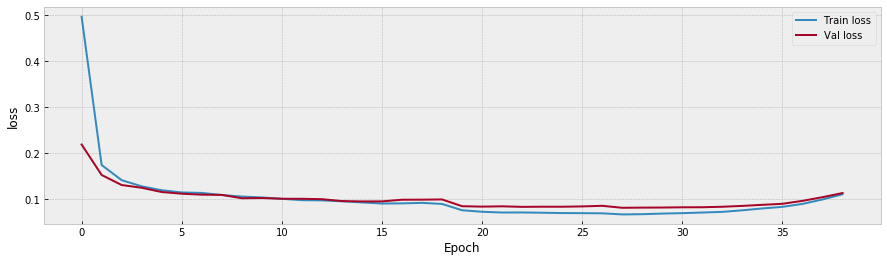

BS:50 train loss: 0.06725 val loss:0.08166


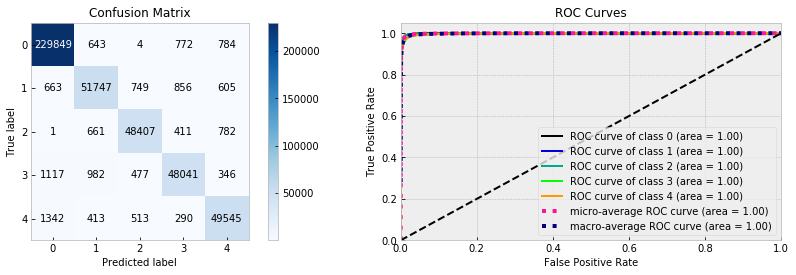

In [24]:
model = keras.models.load_model('my_checkpoint.h5')
model.summary()

plot_history(history, model.metrics_names)

print(f'BS:{BS} train loss: {np.min(history.history["loss"]):.5f} val loss:{np.min(history.history["val_loss"]):.5f}')

model.reset_states()

cv_pred_proba = model.predict(X_cv, use_multiprocessing=True)
cv_pred_proba = cv_pred_proba.reshape(-1, TARGET_TYPES)
cv_pred = cv_pred_proba.argmax(axis=1)

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(1, 2, 1)
skplt.metrics.plot_confusion_matrix(y_cv, cv_pred, ax=ax1)
ax2 = fig.add_subplot(1, 2, 2)
skplt.metrics.plot_roc(y_cv, cv_pred_proba, ax=ax2)
plt.show()

## Submit RNN Result

In [0]:
X_test = df_test[['GR']]
X_test = (X_test.values - center)/scale
X_test = X_test.reshape(-1, BLOCK, FEATURES_NUM)

model = keras.models.load_model('my_checkpoint.h5')

test_pred_proba = model.predict(X_test, use_multiprocessing=True)
test_pred_proba = test_pred_proba.reshape(-1, TARGET_TYPES)
test_pred = test_pred_proba.argmax(axis=1)

pd.DataFrame(test_pred, index=df_test.index, columns=['label']).to_csv('submission.csv')

In [0]:
files.download('submission.csv')

## Tree models

In [0]:

X, y = data.iloc[:, 1:], data.iloc[:, :1]

X, _, y, _ = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.8)
X, X_oof, y, y_oof = train_test_split(X, y, random_state=RS, shuffle=False, test_size=0.1)


n_folds = 2
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RS)
model = XGBClassifier(objective="multi:softprob", random_state=RS)
scores = cross_val_score(model, X, y, scoring='roc_auc_ovr', verbose=1, n_jobs=-1, cv=skf)

model.fit(X, y,
        eval_set=[(X_oof, y_oof)],
        early_stopping_rounds=200,
        verbose=False,
        #eval_metric = 'roc_auc_ovr', 
        )

# estimate OOF
oof = oof_estimate_plot(model)
print(f'# {type(model).__name__} RS:{RS} {n_folds}x CV: {np.mean(scores):.5f} ± {np.std(scores):.5f} OOF: {oof:.5f} ~{[x for x in FTS if x not in X.columns]}')

plot_cv_scores(scores)

## Submit the result

In [0]:
X_test = df_test[['GR']]
#X_test = (X_test.values - center)/scale

test_pred_proba = model.predict_proba(X_test) #, use_multiprocessing=True)
test_pred = test_pred_proba.argmax(axis=1)

df_test_pred=pd.DataFrame(test_pred, index=df_test.index, columns=['label']).to_csv('submission.csv')
df_test_pred

In [0]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)